In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random
import seaborn as sns
import umap
from keras.models import load_model
from sklearn.decomposition import PCA
import pickle

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

from ponyo import utils

from numpy.random import seed
random_state = 123
seed(random_state)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "config_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
project_id = params['project_id']

In [4]:
# Load real template experiment
template_data_file = params['template_data_file']

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    project_id+"_groups.tsv")

In [5]:
# Read data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

template_data.head()

ARHGAP45   ZNF610  PPP1R3B     RBBP7  CCDC185  GPATCH3  C1orf159  \
SRR493937  35.76295  0.27136  7.85996   7.28877  0.00000  3.96190   2.38090   
SRR493938  35.64590  0.20162  7.36596   7.48389  0.01228  3.87150   2.04956   
SRR493939  12.08493  1.14617  7.68997  16.50202  0.11537  4.09678   4.41303   
SRR493940  12.23950  1.10425  7.73464  16.21860  0.13944  4.83895   4.28869   
SRR493941  19.12283  0.72225  6.41446   7.21482  0.00000  3.72723   2.23692   

             DECR2    NAA11  KRTAP4-6    ...         FBXL6        UBC  \
SRR493937  2.57783  0.00000   0.01379    ...       7.55171  772.17618   
SRR493938  2.11685  0.01095   0.01384    ...       7.72931  766.48797   
SRR493939  8.86896  0.01063   0.00631    ...      18.54330  517.16138   
SRR493940  8.95739  0.00000   0.00000    ...      17.77992  518.81470   
SRR493941  3.57803  0.00000   0.00000    ...       7.75220  356.84288   

              CD1A  OLFML2B  CACNA2D4      EID1  CHRNA10     SCYL2    SCRT1  \
SRR493937  1.13939  7.29955   0.57151  30.02832  1.35471   5.57120  0.01025   
SRR493938  1.24462  7.35087   0.57616  31.32576  1.23270   5.56860  0.02443   
SRR493939  4.46329  5.38447   0.38758  39.22670  0.49594  13.58227  0.06502   
SRR493940  4.51526  6.07903   0.44853  39.77127  0.66858  13.77175  0.06845   
SRR493941  0.59906  6.97734   0.53997  35.10940  0.51815   5.23799  0.00535   

              POLR2L  
SRR493937   75.14746  
SRR493938   73.24420  
SRR493939  100.52003  
SRR493940   94.96260  
SRR493941  104.47096  

[5 rows x 17788 columns]

In [6]:
"""# Try different partitions of the data
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]
template_data = template_data.drop(smRNA_samples)
print(template_data.shape)
template_data.head()"""

'# Try different partitions of the data\nsmRNA_samples = ["SRR493961",\n                 "SRR493962",\n                 "SRR493963",\n                 "SRR493964",\n                 "SRR493965",\n                 "SRR493966",\n                 "SRR493967",\n                 "SRR493968",\n                 "SRR493969",\n                 "SRR493970",\n                 "SRR493971",\n                 "SRR493972"]\ntemplate_data = template_data.drop(smRNA_samples)\nprint(template_data.shape)\ntemplate_data.head()'

In [7]:
# Read metadata
metadata = pd.read_csv(
    metadata_file,
    header=0,
    sep='\t',
    index_col=0)

metadata.head()

source
Sample           
SRR493937  Normal
SRR493938  Normal
SRR493939   Tumor
SRR493940   Tumor
SRR493941  Normal

In [8]:
# PCA encode
pca = PCA(n_components=2)

model = pca.fit(template_data)
template_PCAencoded = model.transform(template_data)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded ,
                                         index=template_data.index,
                                         columns=['1','2'])

In [9]:
# Add tumor/normal labels
template_data_labeled = pd.merge(template_PCAencoded_df, metadata, left_index=True, right_index=True)
template_data_labeled

1             2  source
SRR493937   -767.659946   -703.769005  Normal
SRR493938   -772.376619   -706.609145  Normal
SRR493939    131.798770   -124.914753   Tumor
SRR493940    134.699795   -125.695189   Tumor
SRR493941  -5865.981377  -1327.393014  Normal
SRR493942  -5877.232675  -1334.506382  Normal
SRR493943   3818.332918  -1751.944632   Tumor
SRR493944   3820.906850  -1755.312821   Tumor
SRR493945  -3452.214591   -532.865473  Normal
SRR493946  -3446.609998   -530.805669  Normal
SRR493947   2223.916163   2846.648944   Tumor
SRR493948   2103.365132   2609.962914   Tumor
SRR493949  -2694.601555  -1396.427508  Normal
SRR493950  -2738.815325  -1425.255047  Normal
SRR493951  12012.396230  -6571.917699   Tumor
SRR493952  11999.756121  -6562.313536   Tumor
SRR493953  -6033.810499  -1423.539787  Normal
SRR493954  -6052.828523  -1429.888774  Normal
SRR493955    304.617502    561.608042   Tumor
SRR493956    306.896711    566.696352   Tumor
SRR493957  -4136.654469  -1015.562692  Normal
SRR493958  -4116.164640  -1011.839727  Normal
SRR493959   4563.829323  11613.534455   Tumor
SRR493960   4534.434703  11532.110144   Tumor

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


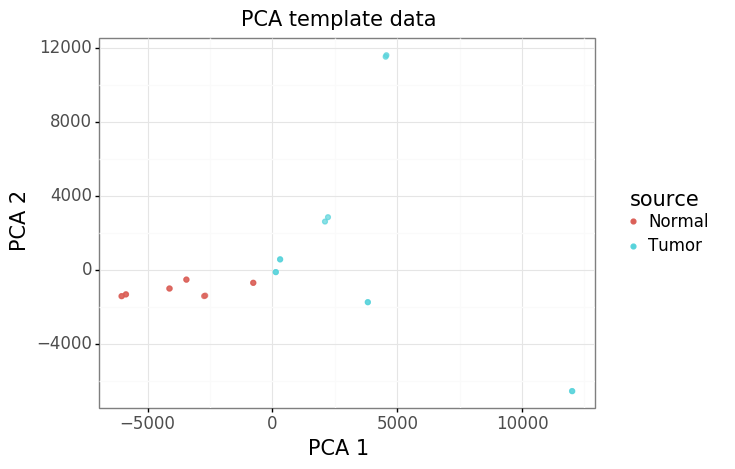

<ggplot: (8745835317233)>


In [10]:
# Plot
fig = ggplot(template_data_labeled, aes(x='1', y='2'))
fig += geom_point(aes(color='source'), alpha=0.7)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA template data')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)